<p align="left">
  <a href="https://colab.research.google.com/github/fernandoarcevega/AI_Workshop/blob/main/Part_2/03_MLP_SGD/03_MLP_SGD_mnl.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200">
  </a>
</p>

In [ ]:
###############################################
# Author 1: Wilfrido Gómez-Flores (CINVESTAV) #
# Author 2: Fernando Arce-Vega (CIO)          #
# e-mail 1: wilfrido.gomez@cinvestav.mx       #
# e-mail 2: farce@cio.mx                      #
# Date:     nov/03/2025                       #
# Subject:  Multi-layer perceptron - SGD      #
###############################################

In [ ]:
# Libraries
import numpy as np                                                    # Numerical array operations
import matplotlib.pyplot as plt                                       # Data plotting/visualization
import os                                                             # Interaction with the operating system
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Model evaluation
import tensorflow as tf                                               # Machine learning

In [ ]:
# Download MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Check feature and targets shapes for training and testing
print(f'Training features shape: {x_train.shape}')
print(f'Training targets shape:  {y_train.shape}\n')
print(f'Testing features shape:  {x_test.shape}')
print(f'Testing targets shape:   {y_test.shape}')

Training features shape: (60000, 28, 28)
Training targets shape:  (60000,)

Testing features shape:  (10000, 28, 28)
Testing targets shape:   (10000,)


In [ ]:
# Split dataset
def split_dataset(x_train, y_train, x_test, y_test, n_train, n_test):

  # Unique classes
  unique_classes = np.unique(y_train)

  Xtr = []
  Ytr = []
  Xtt = []
  Ytt = []

  # Saving examples per class
  for clas in unique_classes:
    indices_train = np.where(y_train == clas)[0][:n_train]
    indices_test = np.where(y_test == clas)[0][:n_test]

    Xtr.extend(x_train[indices_train])
    Ytr.extend(y_train[indices_train])
    Xtt.extend(x_test[indices_test])
    Ytt.extend(y_test[indices_test])

  Xtr = np.array(Xtr)
  Ytr = np.array(Ytr)
  Xtt = np.array(Xtt)
  Ytt = np.array(Ytt)

  # Shuffle data
  indices_train = np.random.permutation(len(Ytr))
  indices_test = np.random.permutation(len(Ytt))

  Xtr = Xtr[indices_train]
  Ytr = Ytr[indices_train]
  Xtt = Xtt[indices_test]
  Ytt = Ytt[indices_test]

  return Xtr, Ytr, Xtt, Ytt

In [ ]:
# Shuffle data
def shuffle(B, n):
    id = np.random.permutation(n)
    return B[id]

In [ ]:
# Split dataset into mini-batches
def batchify(n, nb):
    B = np.zeros(n, dtype=int)
    p = 0
    c = 0

    while p < n:
        q = 0
        c += 1

        while p < n and q < nb:
            p += 1
            q += 1
            B[p - 1] = c

    return B, c

SGD-based training algorithm:

$$
\begin{align*}
& \textbf{input:} \quad X = \{(\mathbf{x}_i, \mathbf{t}_i)|i = 1, \dots, n\}, \eta, n_b, r_{\max} \\
\\
1: \quad & w_{ji} \leftarrow \text{rand}, w_{kj} \leftarrow \text{rand} && \triangleright \text{Weight initialization} \\
2: \quad & X_B \leftarrow \text{Batchify}(X, n_b) && \triangleright \text{Split dataset into mini-batches} \\
3: \quad & \textbf{for } r = 1, 2, \dots, r_{\max} \textbf{ do} && \triangleright \text{For each epoch} \\
4: \quad & \qquad X_B \leftarrow \text{Shuffle}(X_B) && \triangleright \text{Random permutation of mini-batch data} \\
5: \quad & \qquad \textbf{for each } X_b \in X_B \textbf{ do} && \triangleright \text{For each mini-batch} \\
6: \quad & \qquad \qquad \Delta w_{ji} \leftarrow 0, \Delta w_{kj} \leftarrow 0 \\
7: \quad & \qquad \qquad \textbf{for each } \mathbf{x}_l \in X_b \textbf{ do} && \triangleright \text{For each sample in the mini-batch} \\
8: \quad & \qquad \qquad \qquad z_k \leftarrow \text{MLP}(\mathbf{x}_l, w_{ji}, w_{kj}) && \triangleright \text{Feedforward} \\
9: \quad & \qquad \qquad \qquad \Delta w_{kj} \leftarrow \Delta w_{kj} + \delta_k y_j && \triangleright \text{Delta rules} \\
10: \quad & \qquad \qquad \qquad \Delta w_{ji} \leftarrow \Delta w_{ji} + \delta_j x_{li} \\
11: \quad & \qquad w_{kj} \leftarrow (1 - \eta)w_{kj} - \eta\Delta w_{kj} && \triangleright \text{Weight updates} \\
12: \quad & \qquad w_{ji} \leftarrow (1 - \eta)w_{ji} - \eta\Delta w_{ji} \\
\\
& \textbf{return:} \quad w_{ji}, w_{kj}
\end{align*}
$$

In [ ]:
# MLP trained by SGD
def mlp_sgd(X, Y, h, eta, l, nb, epochMax):
    c = int(np.max(Y))
    n, d = X.shape
    c = int(np.max(Y)) + 1
    tk = np.eye(c)[Y]

    X = np.hstack((np.ones((n, 1)), X))   # Add dummy inputs for the biases calculation

    # Weights initialization
    rd = lambda a, b, s, t: a + (b - a) * np.random.rand(s, t)        # Xavier initialization
    Wji = rd(-np.sqrt(6 / (d + h)), np.sqrt(6 / (d + h)), h, d + 1)   # input-hidden layer weights
    Wkj = rd(-np.sqrt(6 / (h + c)), np.sqrt(6 / (h + c)), c, h + 1)   # hidden-output layer weights

    # Training loop
    B, nbatch = batchify(n, nb)   # Split dataset into mini-batches
    Jn = np.zeros(epochMax)       # Save loss function

    for t in range(epochMax):
        B = shuffle(B, n)         # Shuffle data every epoch

        for b in range(1, nbatch + 1):
            id = (B == b)
            Xb = X[id, :]
            tb = tk[id, :]

            # Compute gradients
            Dwji, Dwkj, Jn[t] = deltaRules(Xb, tb, Wji, Wkj, l)

            # Weight updates
            Wji = (1 - eta * l) * Wji - eta * Dwji  # input-hidden
            Wkj = (1 - eta * l) * Wkj - eta * Dwkj  # hidden-output

    return Wji, Wkj, Jn

In [ ]:
# Compute gradients
def deltaRules(X, tk, Wji, Wkj, l):
    # Functions
    sg = lambda x: 1 / (1 + np.exp(-x))                                     # Sigmoid activation function
    sm = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)     # Softmax function
    ce = lambda t, z: -np.sum(t * np.log(z + np.finfo(float).eps), axis=1)  # Cross-entropy loss function

    # Forward
    yj = sg(X @ Wji.T)                              # Hidden layer response
    yj = np.hstack((np.ones((X.shape[0], 1)), yj))  # Add dummy inputs
    zk = sm(yj @ Wkj.T)                             # Output layer response
    L2 = (l / 2) * (np.sum(Wji ** 2) + np.sum(Wkj ** 2))
    Jt = np.mean(ce(tk, zk)) + L2                   # Regularized cross-entropy loss

    # Backward
    h = Wji.shape[0]
    dk = zk - tk                      # delta k
    Dwkj = dk.T @ yj                  # Delta rule hidden-output
    dj = (dk @ Wkj) * (yj * (1 - yj)) # delta j
    Dwji = dj[:, 1:h + 1].T @ X       # Delta rule input-hidden

    return Dwji, Dwkj, Jt

In [ ]:
# Predict with MLP
def mlp_predict(X, Wji, Wkj):
    sg = lambda x: 1 / (1 + np.exp(-x))                                   # Sigmoid activation function
    sm = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)   # Softmax function
    ones = np.ones((X.shape[0], 1))
    X = np.hstack((ones, X))                                              # Add dummy inputs
    yj = sg(X @ Wji.T)                                                    # Hidden layer response
    yj = np.hstack((ones, yj))                                            # Add dummy inputs
    zk = sm(yj @ Wkj.T)                                                   # Output layer response
    ypp = np.argmax(zk, axis=1, keepdims=True)                            # Classification by maximum probability
    return ypp[:, 0], zk

In [ ]:
# Split data
n_train = 800   # Number of examples for training, for class
n_test = 200    # Number of examples for testing, for class
Xtr, Ytr, Xtt, Ytt = split_dataset(x_train, y_train, x_test, y_test, n_train, n_test)

In [ ]:
# Check feature and targets shapes for training and testing
print(f'Training features shape: {Xtr.shape}')
print(f'Training targets shape:  {Ytr.shape}\n')
print(f'Testing features shape:  {Xtt.shape}')
print(f'Testing targets shape:   {Ytt.shape}')

Training features shape: (8000, 28, 28)
Training targets shape:  (8000,)

Testing features shape:  (2000, 28, 28)
Testing targets shape:   (2000,)


Training images



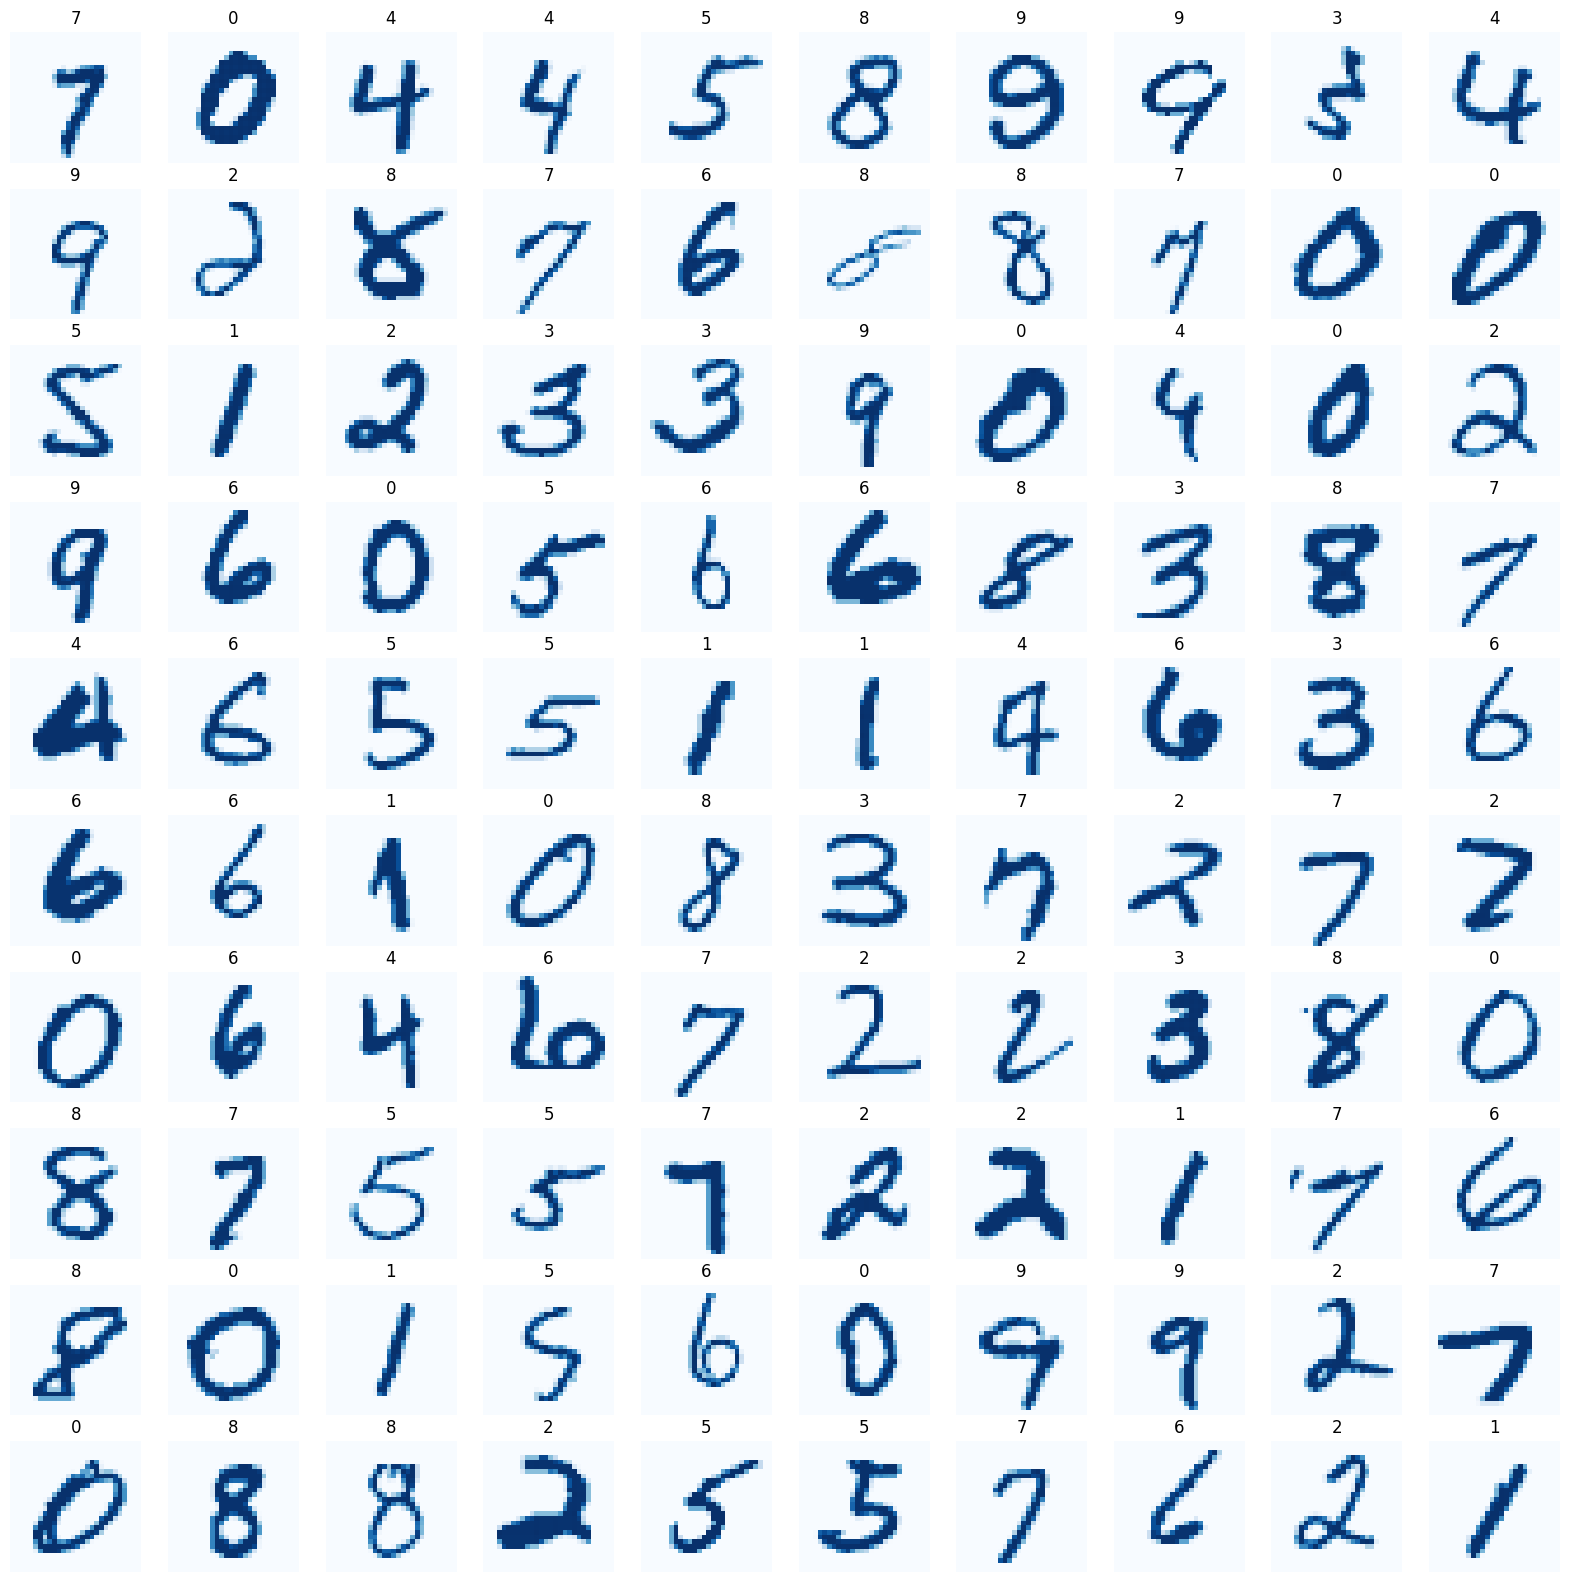

In [ ]:
# Data visualization
ncols = 10
nrows = 10

# Create figure
fig, axs = plt.subplots(figsize = (20, 20))
plt.axis('off')

print('Training images\n')

for i in range(ncols * nrows):

  axs = fig.add_subplot(nrows, ncols, i + 1)
  axs.imshow(Xtr[i], cmap = 'Blues')
  axs.axis('off')

  label = str(Ytr[i])
  plt.title(label)

plt.show()

In [ ]:
# Data preprocessing
Xtr = Xtr.reshape(np.shape(Xtr)[0], -1).astype(float) / 255
Xtt = Xtt.reshape(np.shape(Xtt)[0], -1).astype(float) / 255

In [ ]:
# Check feature and targets shapes for training and testing
print(f'Training features shape: {Xtr.shape}')
print(f'Training targets shape:  {Ytr.shape}\n')
print(f'Testing features shape:  {Xtt.shape}')
print(f'Testing targets shape:   {Ytt.shape}')

Training features shape: (8000, 784)
Training targets shape:  (8000,)

Testing features shape:  (2000, 784)
Testing targets shape:   (2000,)


In [ ]:
# Hyperparameters
h = 20
eta = 1e-3
lam = 1e-4
nb = 128
epochMax = 500

In [ ]:
# Train MLP with mini-batch SGD
Wji, Wkj, Jn = mlp_sgd(Xtr, Ytr, h, eta, lam, nb, epochMax)

In [ ]:
# Predict test data
Ypp, zk = mlp_predict(Xtt, Wji, Wkj)

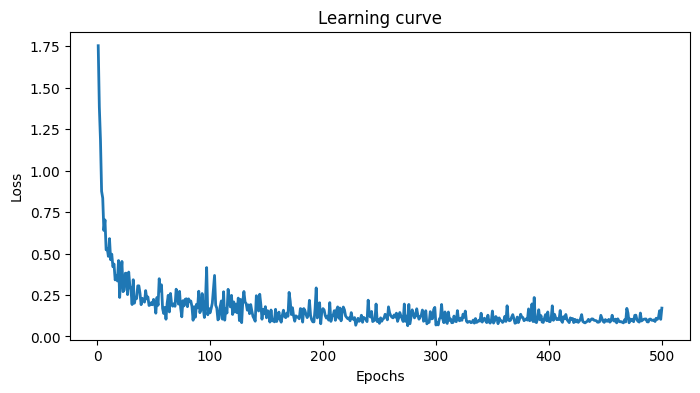

In [ ]:
# Learning curve
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(Jn) + 1), Jn, linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.show()

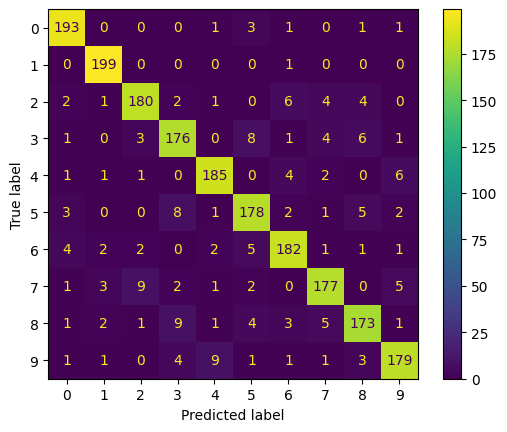

In [ ]:
# Confusion matrix
cm = confusion_matrix(Ytt, Ypp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Print classification error
err = np.mean(Ypp != Ytt)
print(f'Error: {100 * err:.3f}%')

Error: 8.900%


Test images



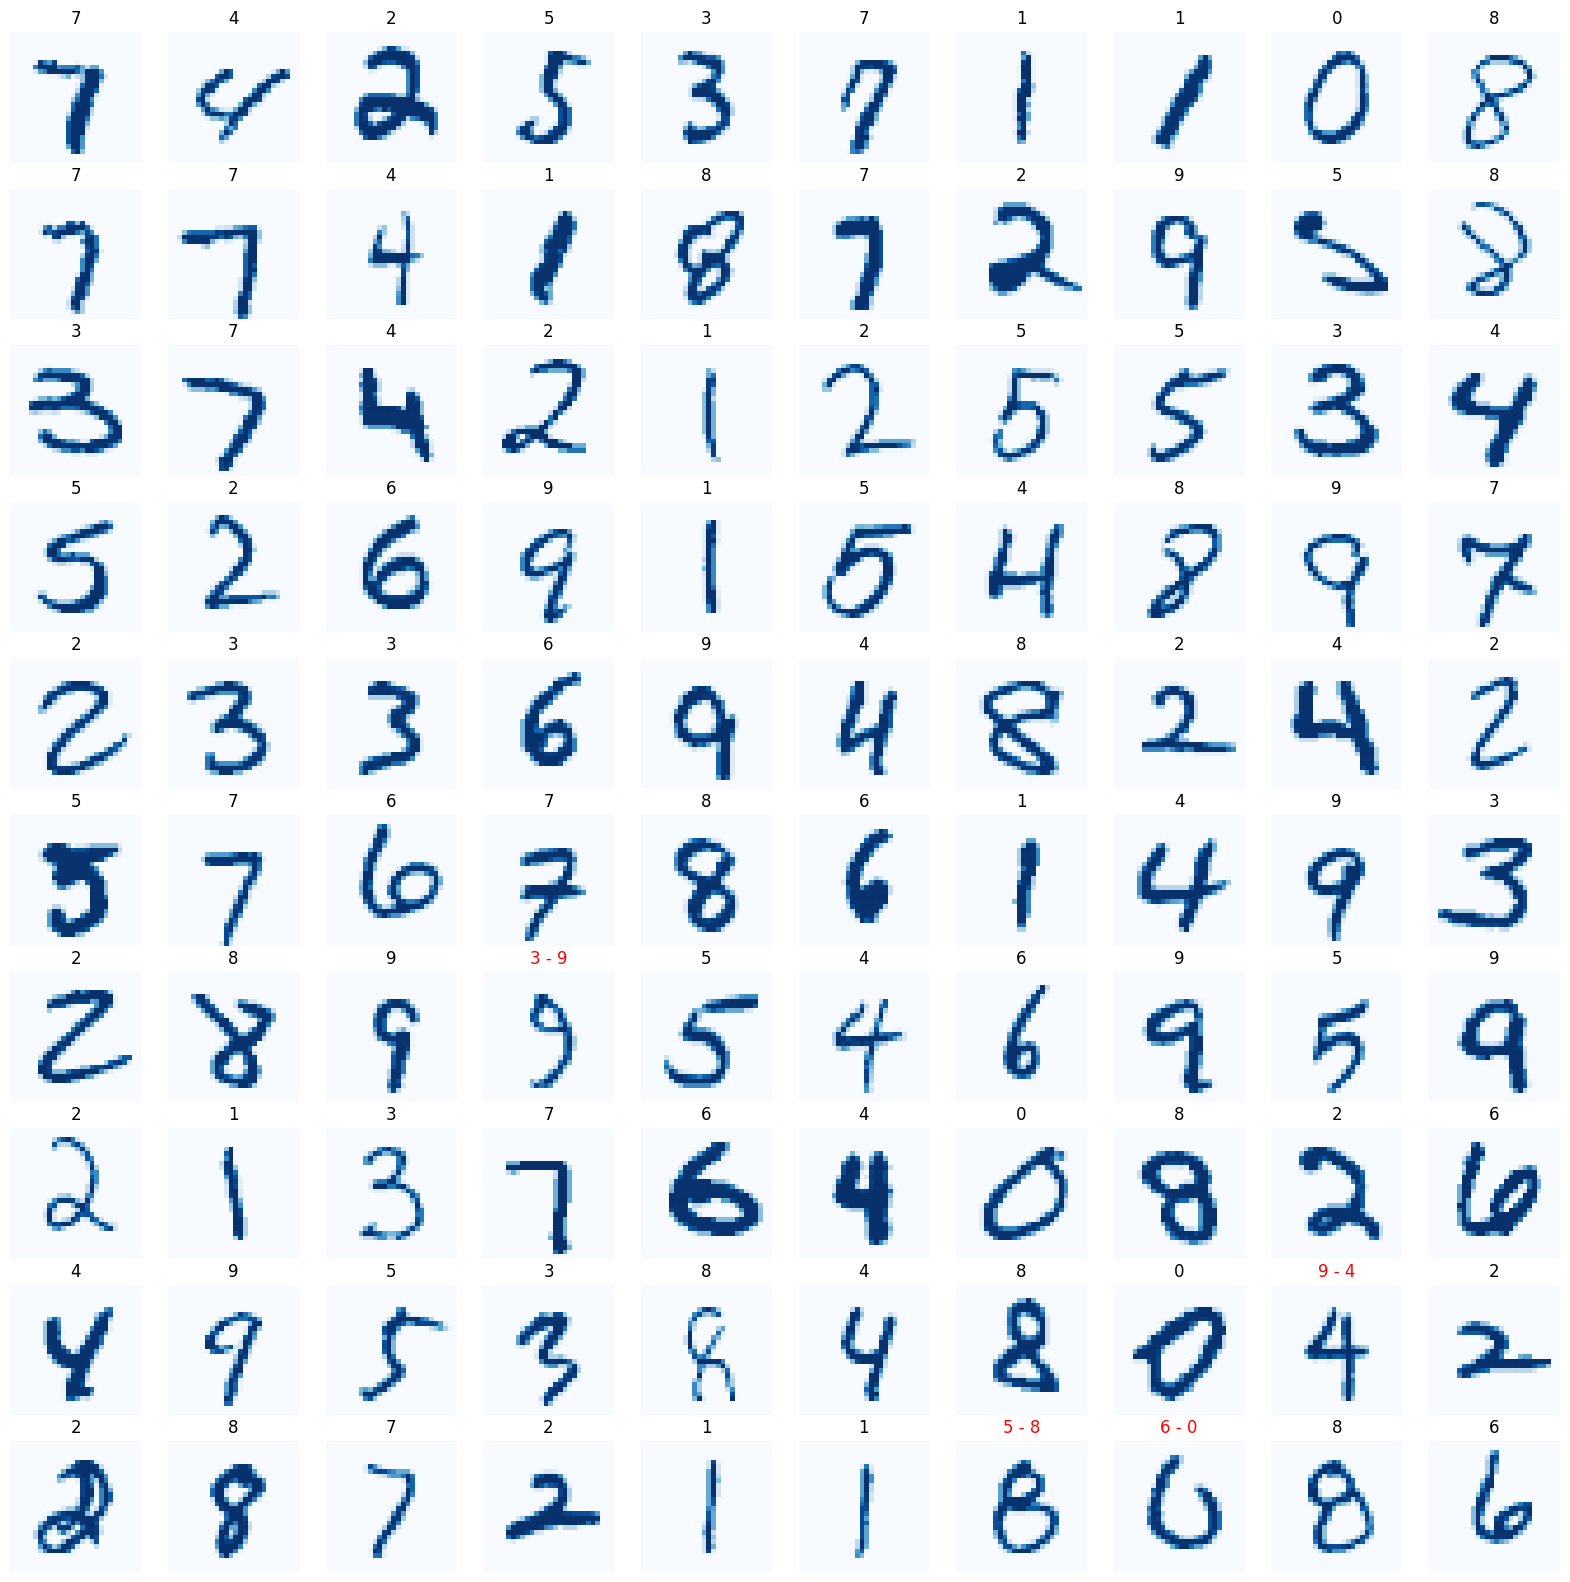

In [ ]:
# Prediction: Data visualization
ncols = 10
nrows = 10

# Create figure
fig, axs = plt.subplots(figsize = (20, 20))
plt.axis('off')

print('Test images\n')
Xtt_plot = Xtt.reshape(np.shape(Xtt)[0], 28, 28)

for i in range(ncols * nrows):

  axs = fig.add_subplot(nrows, ncols, i + 1)
  axs.imshow(Xtt_plot[i], cmap = 'Blues')
  axs.axis('off')

  # Check prediction
  if Ypp[i] != Ytt[i]:
    label = str(Ypp[i]) + ' - ' + str(Ytt[i])
    plt.title(label, color='red')

  else:
    label = str(Ypp[i])
    plt.title(label)


  plt.title(label)

plt.show()